In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

Bring in the separate csvs and concat into a single file

In [2]:
df = pd.read_csv('../../data/intermediate/data_concat.csv')

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/396735133.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/intermediate/data_concat.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949511 entries, 0 to 949510
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                949511 non-null  object 
 1   town                 949511 non-null  object 
 2   flat_type            949511 non-null  object 
 3   block                949511 non-null  object 
 4   street_name          949511 non-null  object 
 5   storey_range         949511 non-null  object 
 6   floor_area_sqm       949511 non-null  float64
 7   flat_model           949511 non-null  object 
 8   lease_commence_date  949511 non-null  int64  
 9   resale_price         949511 non-null  float64
 10  remaining_lease      240461 non-null  object 
 11  year                 949511 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 86.9+ MB


In [4]:
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,year
count,949511.000000,949511.000000,9.495110e+05,949511.000000
mean,95.677121,1988.508689,3.280508e+05,2006.594936
std,25.783714,10.896028,1.773675e+05,9.611320
min,28.000000,1966.000000,5.000000e+03,1990.000000
25%,73.000000,1981.000000,1.958000e+05,1999.000000
50%,93.000000,1986.000000,3.020000e+05,2005.000000
75%,113.000000,1996.000000,4.250000e+05,2015.000000
max,366.700000,2021.000000,1.600000e+06,2025.000000


In [5]:
df.isnull().sum().sort_values(ascending=False)

remaining_lease        709050
month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
year                        0
dtype: int64

In [6]:
df = df.drop_duplicates()
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN,1990
1,1990-01-01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,NaN,1990
2,1990-01-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,NaN,1990
3,1990-01-01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,NaN,1990
4,1990-01-01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,NaN,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
949506,2025-03-01,TAMPINES,4 ROOM,613A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,795000.0,94 years 08 months,2025
949507,2025-03-01,TAMPINES,4 ROOM,608A,TAMPINES NTH DR 1,04 TO 06,93.0,Model A,2020,715000.0,94 years 08 months,2025
949508,2025-03-01,TAMPINES,4 ROOM,609A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,790000.0,94 years 08 months,2025
949509,2025-03-01,TAMPINES,4 ROOM,113,TAMPINES ST 11,04 TO 06,115.0,Model A,1982,700000.0,56 years 05 months,2025


There were 1909 duplicates.

Since majority does not have remaining_lease, and that this can be derived (lease_commence_date + 99 - month) will drop this column first.

In [7]:
df = df.drop(columns=['remaining_lease'])
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,1990
1,1990-01-01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,1990
2,1990-01-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,1990
3,1990-01-01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,1990
4,1990-01-01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,1990
...,...,...,...,...,...,...,...,...,...,...,...
949506,2025-03-01,TAMPINES,4 ROOM,613A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,795000.0,2025
949507,2025-03-01,TAMPINES,4 ROOM,608A,TAMPINES NTH DR 1,04 TO 06,93.0,Model A,2020,715000.0,2025
949508,2025-03-01,TAMPINES,4 ROOM,609A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,790000.0,2025
949509,2025-03-01,TAMPINES,4 ROOM,113,TAMPINES ST 11,04 TO 06,115.0,Model A,1982,700000.0,2025


In [8]:
df["year"] = df["month"].str[:4]
df["month"] = df["month"].str[5:7]
df["day"] = df["month"].str[-2:]
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,day
0,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,1990,01
1,01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,1990,01
2,01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,1990,01
3,01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,1990,01
4,01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,1990,01
...,...,...,...,...,...,...,...,...,...,...,...,...
949506,03,TAMPINES,4 ROOM,613A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,795000.0,2025,03
949507,03,TAMPINES,4 ROOM,608A,TAMPINES NTH DR 1,04 TO 06,93.0,Model A,2020,715000.0,2025,03
949508,03,TAMPINES,4 ROOM,609A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,790000.0,2025,03
949509,03,TAMPINES,4 ROOM,113,TAMPINES ST 11,04 TO 06,115.0,Model A,1982,700000.0,2025,03


In [9]:
df['flat_type'] = df['flat_type'].replace('MULTI GENERATION', 'MULTI-GENERATION')
df['flat_type'].value_counts()

flat_type
4 ROOM              361382
3 ROOM              300562
5 ROOM              200379
EXECUTIVE            71001
2 ROOM               12452
1 ROOM                1281
MULTI-GENERATION       545
Name: count, dtype: int64

In [10]:
df['flat_model'] = df['flat_model'].str.upper()
df['flat_model'] = df['flat_model'].replace('MULTI GENERATION', 'MULTI-GENERATION')
df['flat_model'].value_counts()

flat_model
MODEL A                   273428
IMPROVED                  246514
NEW GENERATION            191164
SIMPLIFIED                 58281
PREMIUM APARTMENT          48966
STANDARD                   42990
APARTMENT                  36165
MAISONETTE                 30171
MODEL A2                   10365
DBSS                        3577
MODEL A-MAISONETTE          2116
ADJOINED FLAT               1278
TERRACE                      703
MULTI-GENERATION             545
TYPE S1                      468
2-ROOM                       260
TYPE S2                      229
IMPROVED-MAISONETTE          128
PREMIUM APARTMENT LOFT       115
PREMIUM MAISONETTE            88
3GEN                          51
Name: count, dtype: int64

In [11]:
df['town'].value_counts()

town
TAMPINES           81484
YISHUN             71389
JURONG WEST        68036
BEDOK              67533
WOODLANDS          67006
ANG MO KIO         52828
HOUGANG            51772
BUKIT BATOK        45671
CHOA CHU KANG      39265
BUKIT MERAH        35134
SENGKANG           34178
PASIR RIS          33684
TOA PAYOH          32171
QUEENSTOWN         29279
GEYLANG            28698
CLEMENTI           28426
BUKIT PANJANG      28354
KALLANG/WHAMPOA    27878
JURONG EAST        25174
SERANGOON          23147
PUNGGOL            22125
BISHAN             21548
SEMBAWANG          14760
MARINE PARADE       8149
CENTRAL AREA        7284
BUKIT TIMAH         2566
LIM CHU KANG          63
Name: count, dtype: int64

In [12]:
# mapping towns to regions for a larger picture look

town_to_region = {
    "TAMPINES": "East",
    "YISHUN": "North",
    "JURONG WEST": "West",
    "BEDOK": "East",
    "WOODLANDS": "North",
    "ANG MO KIO": "North-East",
    "HOUGANG": "North-East",
    "BUKIT BATOK": "West",
    "CHOA CHU KANG": "West",
    "BUKIT MERAH": "Central",
    "SENGKANG": "North-East",
    "PASIR RIS": "East",
    "TOA PAYOH": "Central",
    "QUEENSTOWN": "Central",
    "GEYLANG": "Central",
    "CLEMENTI": "West",
    "BUKIT PANJANG": "West",
    "KALLANG/WHAMPOA": "Central",
    "JURONG EAST": "West",
    "SERANGOON": "North-East",
    "PUNGGOL": "North-East",
    "BISHAN": "Central",
    "SEMBAWANG": "North",
    "MARINE PARADE": "East",
    "CENTRAL AREA": "Central",
    "BUKIT TIMAH": "Central",
    "LIM CHU KANG": "West"
}

df["region"] = df["town"].map(town_to_region)

In [13]:
df['storey_range'].value_counts()

storey_range
04 TO 06    237176
07 TO 09    214359
01 TO 03    190155
10 TO 12    182581
13 TO 15     64135
16 TO 18     25094
19 TO 21     11839
22 TO 24      7701
25 TO 27      3646
01 TO 05      2696
06 TO 10      2472
28 TO 30      1772
11 TO 15      1259
31 TO 33       707
34 TO 36       645
37 TO 39       550
40 TO 42       266
16 TO 20       265
21 TO 25        92
43 TO 45        71
46 TO 48        53
26 TO 30        39
49 TO 51        20
36 TO 40         7
31 TO 35         2
Name: count, dtype: int64

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/3376952713.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_prices_region, x="region", y="resale_price", palette="viridis")


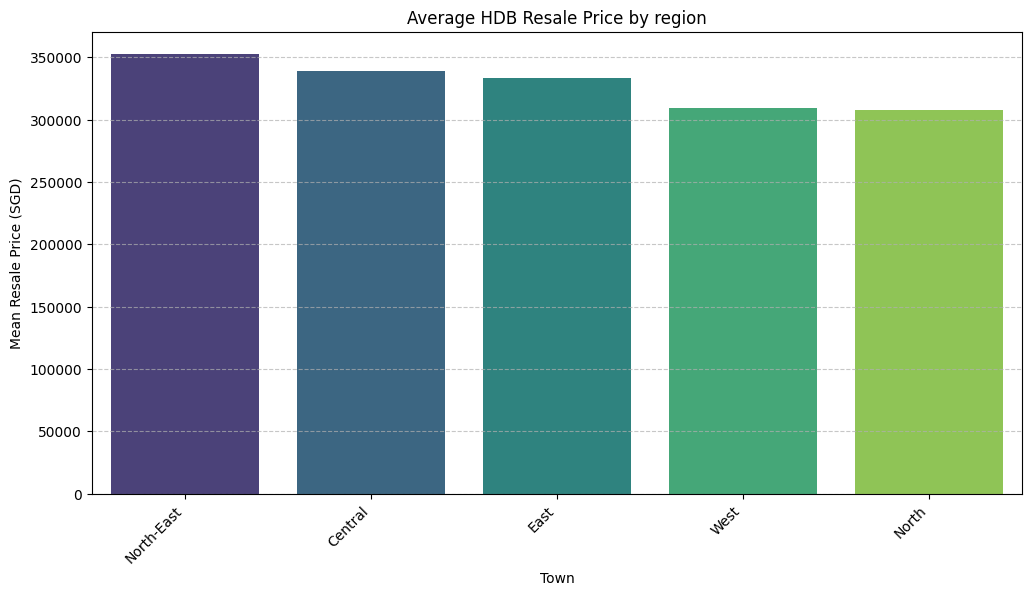

In [14]:
mean_prices_region = df.groupby("region")["resale_price"].mean().reset_index()

mean_prices_region = mean_prices_region.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_prices_region, x="region", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average HDB Resale Price by region")
plt.xlabel("Town")
plt.ylabel("Mean Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/1162570209.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_prices_region, x="region", y="resale_price", palette="viridis")


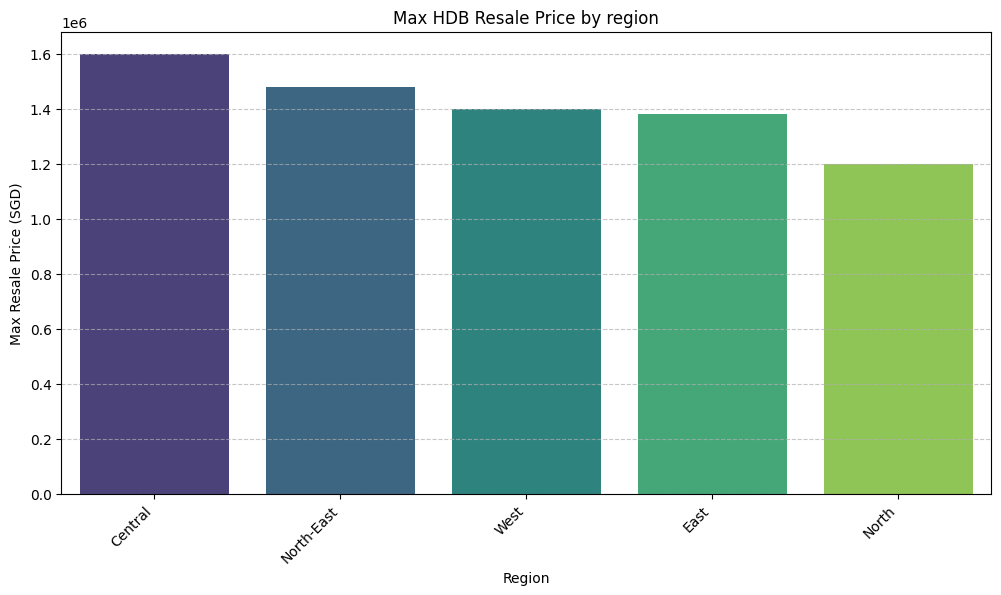

In [15]:
max_prices_region = df.groupby("region")["resale_price"].max().reset_index()

max_prices_region = max_prices_region.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_prices_region, x="region", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max HDB Resale Price by region")
plt.xlabel("Region")
plt.ylabel("Max Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/2027457744.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price_models, x="flat_model", y="resale_price", palette="viridis")


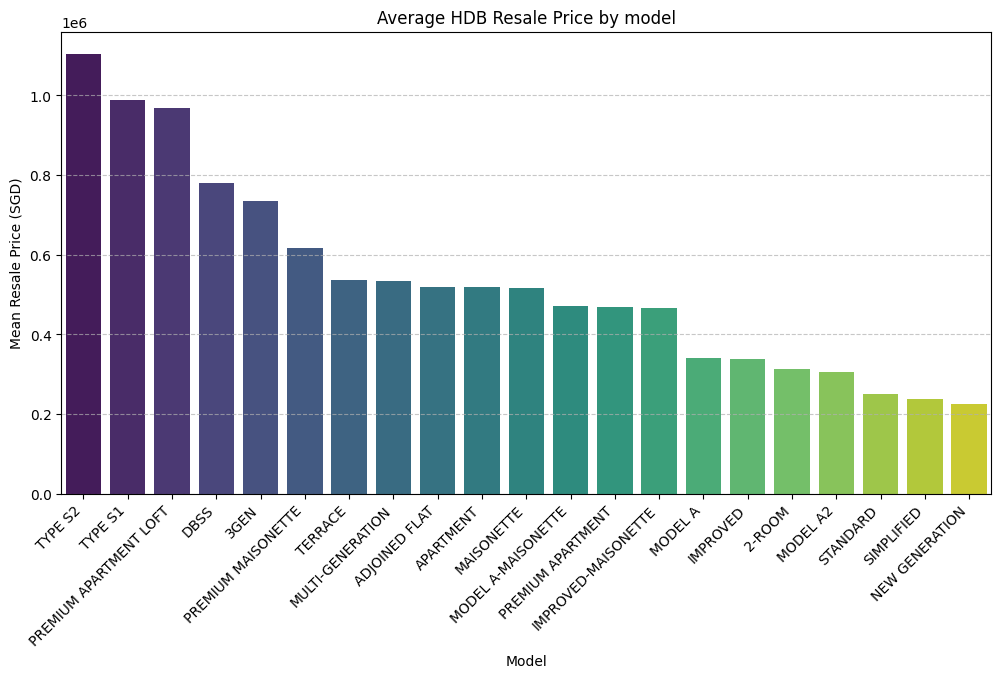

In [16]:
mean_price_models = df.groupby("flat_model")["resale_price"].mean().reset_index()

mean_price_models = mean_price_models.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_price_models, x="flat_model", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average HDB Resale Price by model")
plt.xlabel("Model")
plt.ylabel("Mean Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/1684638120.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_price_models, x="flat_model", y="resale_price", palette="viridis")


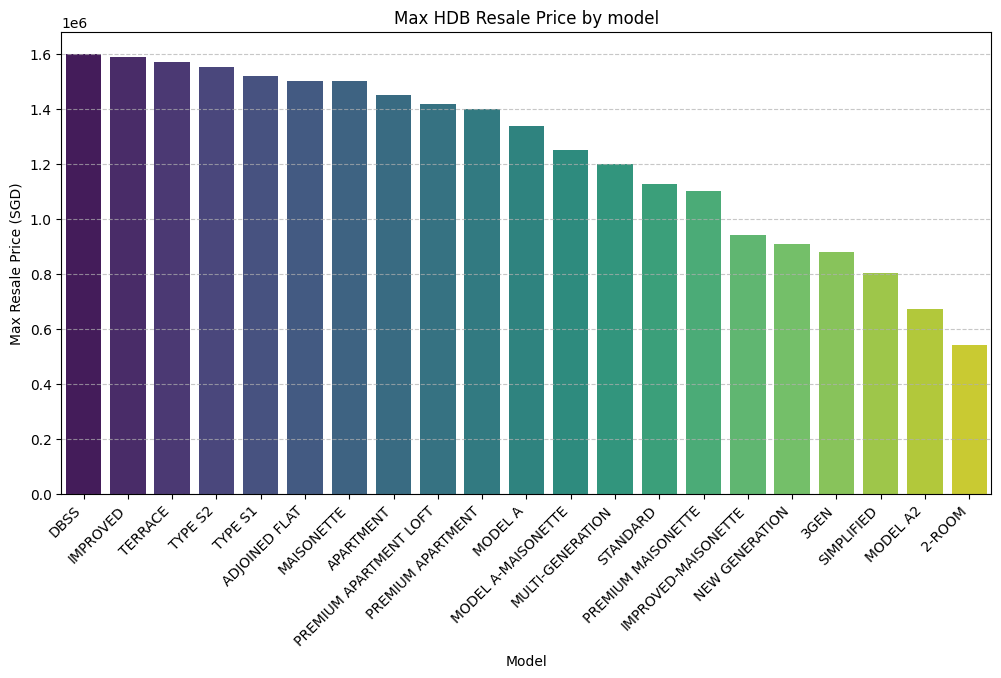

In [17]:
max_price_models = df.groupby("flat_model")["resale_price"].max().reset_index()

max_price_models = max_price_models.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_price_models, x="flat_model", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max HDB Resale Price by model")
plt.xlabel("Model")
plt.ylabel("Max Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/3841027202.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price_types, x="flat_type", y="resale_price", palette="viridis")


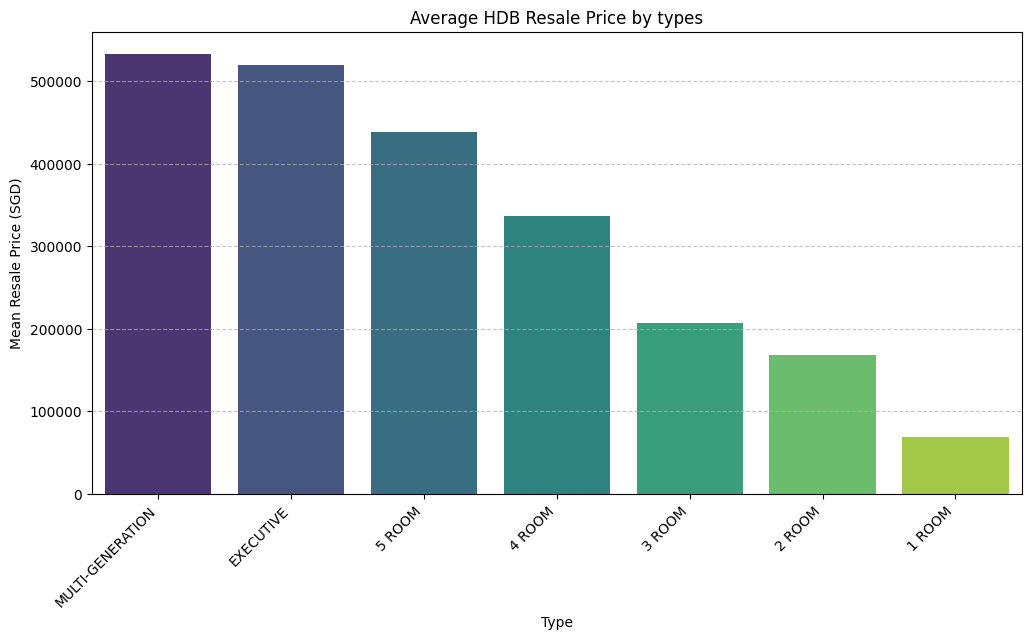

In [18]:
mean_price_types = df.groupby("flat_type")["resale_price"].mean().reset_index()

mean_price_types = mean_price_types.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_price_types, x="flat_type", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average HDB Resale Price by types")
plt.xlabel("Type")
plt.ylabel("Mean Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/1791567037.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_price_types, x="flat_type", y="resale_price", palette="viridis")


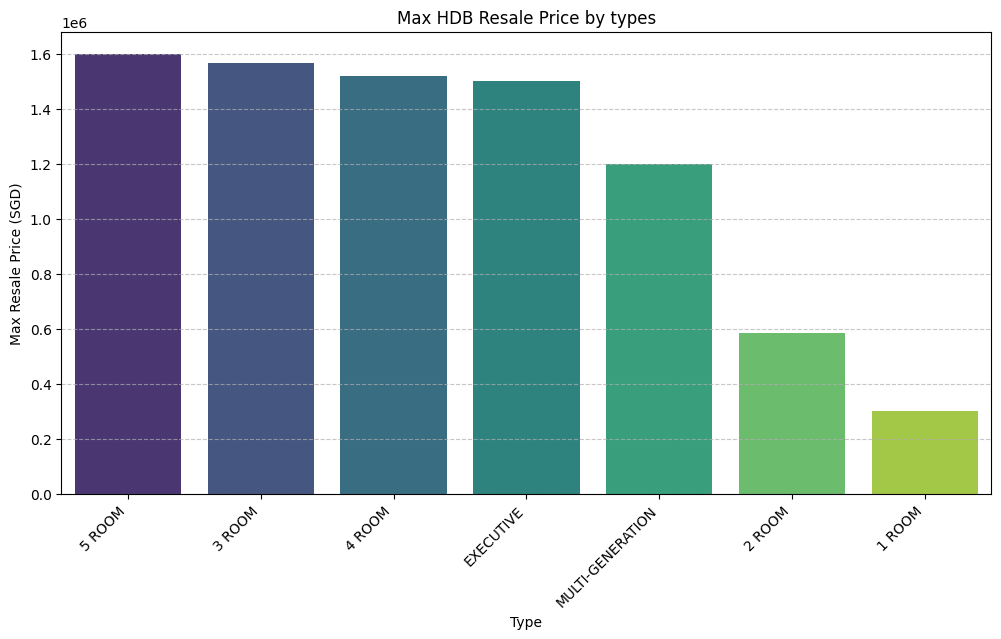

In [19]:
max_price_types = df.groupby("flat_type")["resale_price"].max().reset_index()

max_price_types = max_price_types.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_price_types, x="flat_type", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max HDB Resale Price by types")
plt.xlabel("Type")
plt.ylabel("Max Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

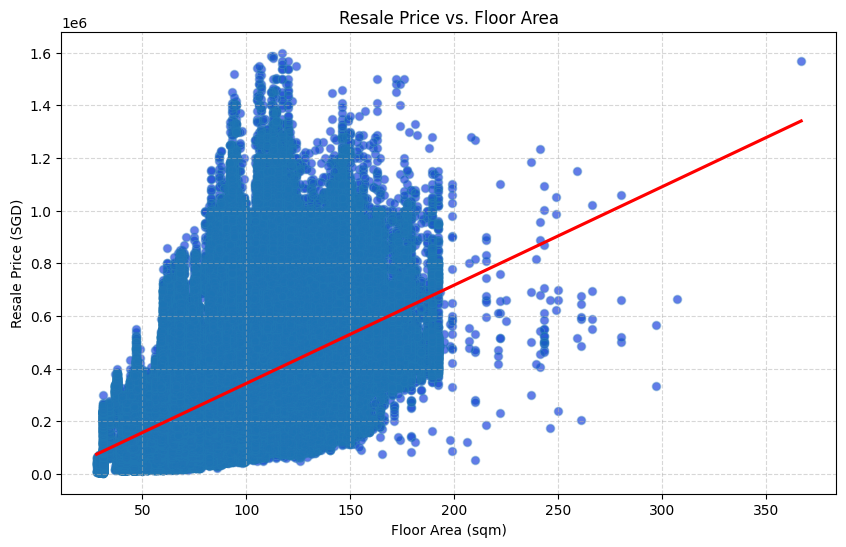

In [20]:
# Set figure size
plt.figure(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(data=df, x="floor_area_sqm", y="resale_price", alpha=0.5, color="blue")
sns.regplot(data=df, x="floor_area_sqm", y="resale_price", scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})

# Add labels and title
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Resale Price (SGD)")
plt.title("Resale Price vs. Floor Area")
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/1269994500.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="year", y="resale_price", estimator="mean", ci=None)


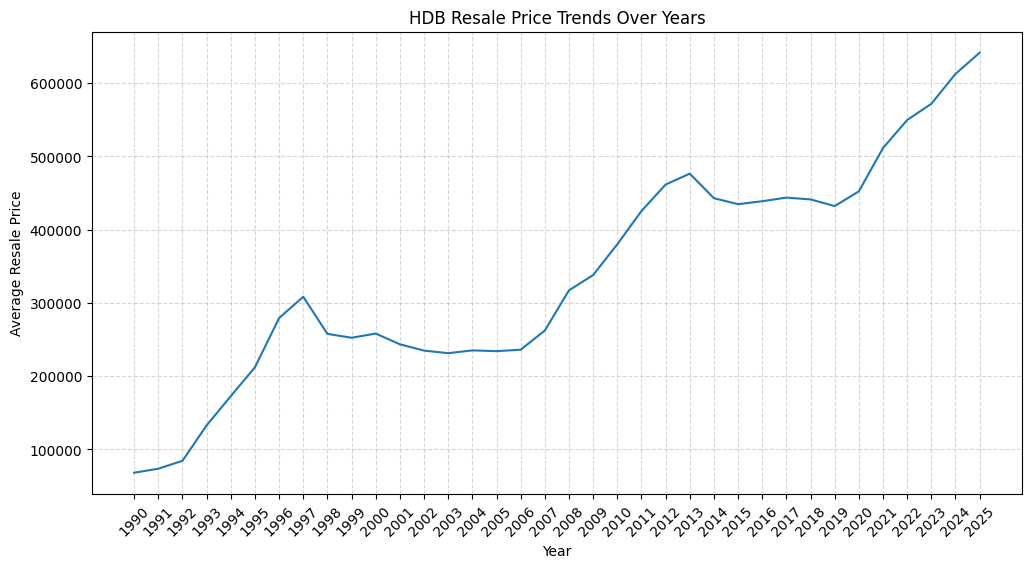

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="year", y="resale_price", estimator="mean", ci=None)
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Average Resale Price")
plt.title("HDB Resale Price Trends Over Years")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/804481909.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="year", y="resale_price", estimator="max", ci=None)


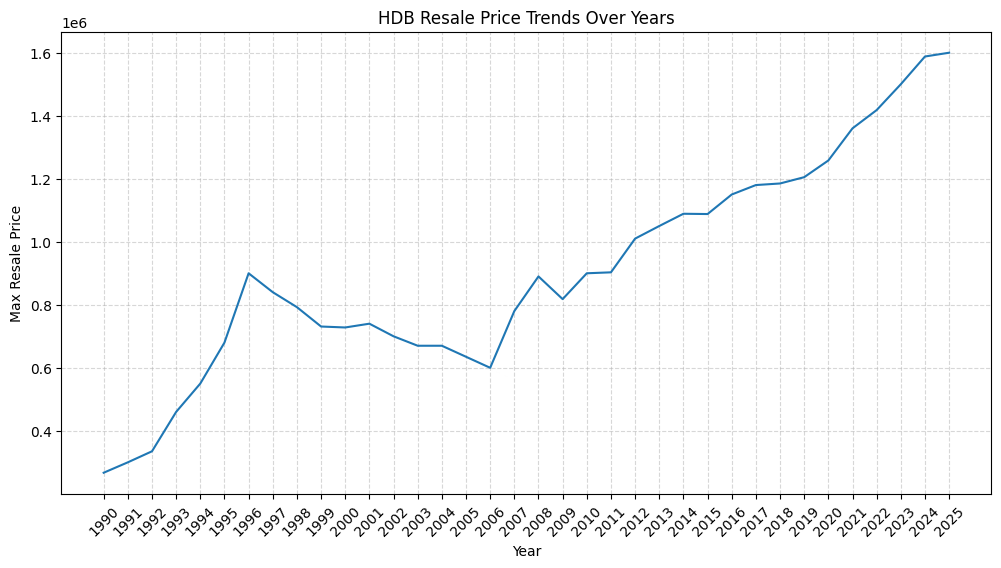

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="year", y="resale_price", estimator="max", ci=None)
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Max Resale Price")
plt.title("HDB Resale Price Trends Over Years")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/422492354.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="month", y="resale_price", estimator="mean", ci=None)


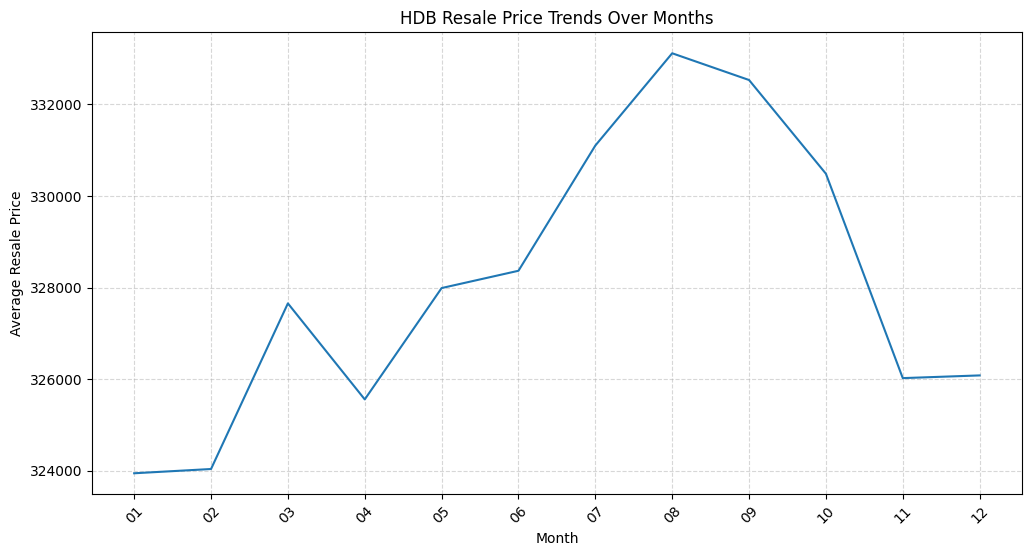

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="month", y="resale_price", estimator="mean", ci=None)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Average Resale Price")
plt.title("HDB Resale Price Trends Over Months")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_19853/1308897692.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="month", y="resale_price", estimator="max", ci=None)


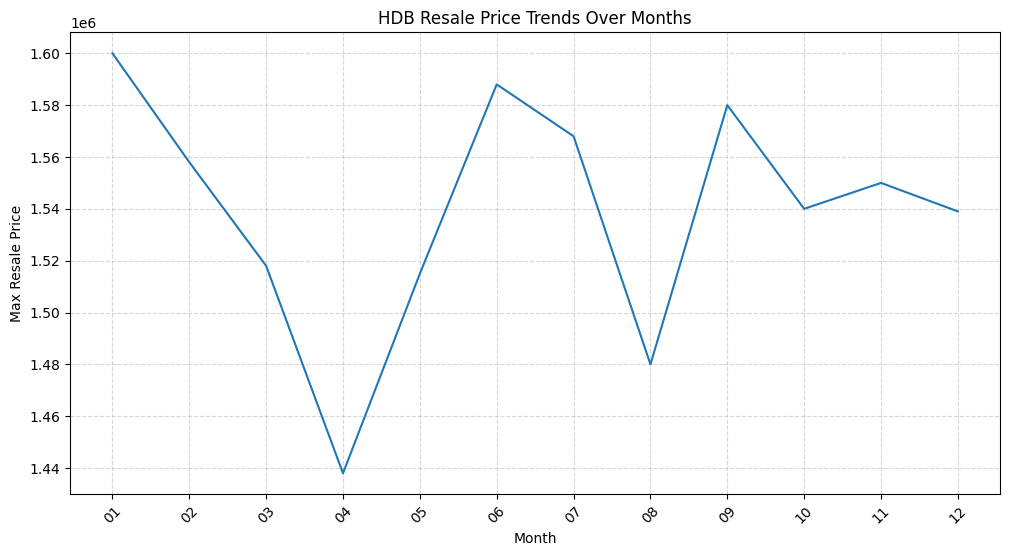

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="month", y="resale_price", estimator="max", ci=None)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Max Resale Price")
plt.title("HDB Resale Price Trends Over Months")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()